# Importing the Libraries

In [2]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

# Getting the Data

In [3]:
data_path = '/kaggle/input/labeled-chest-xray-images/chest_xray'

# Data Exploration

In [4]:
class_name = ['NORMAL', 'PNEUMONIA']
def get_list_files(dirName):
    """
    input - directory location.
    output - list the files in the directory.
    """
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])

files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [5]:
print("Number of train samples in Normal category {}". format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(1449, 1554)


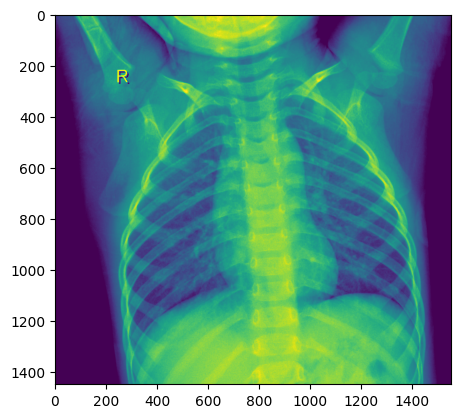

In [6]:
# View a smaple of the images.

rand_img_no = np.random.randint(0, len(files_list_normal_train))
img = data_path + '/train/NORMAL/' + files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)

#display(Image.open(img, 'r'),)

img = mpimg.imread(img)
implot = plt.imshow(img)
plt.show()

(712, 992)


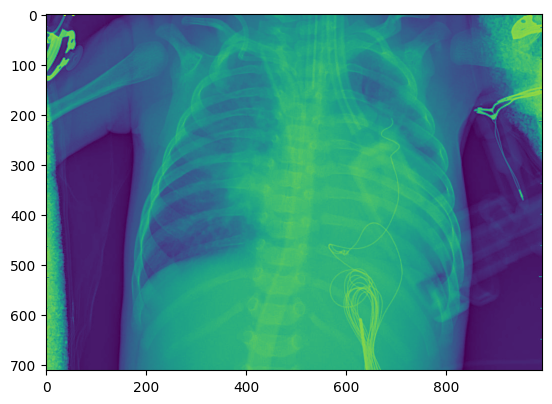

In [7]:
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

# Data Loader

In [8]:
# we will resize and crop the images to uniform size of (24 X 24)
# convert the images to tensors for the pytorch framework.
# normalize the images with mean and standard deviation values.
# considering 3 channels for image, we'll provide 3 values fo each channel.
# we need one combination of mean and standard deviation.

train_transform  = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.48, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform = test_transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

class_names = train_data.classes

In [9]:
print(class_names)
print(f'Number of train images:  {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images:  5232
Number of test images: 624


# Defining the Model

In [10]:
# ReLu Activation Function.
# 12 Convoltion blocks.
# 1 Conv block to set up the input, 1 Conv block to set up the output.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #input Block
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                                                  padding=0, 
                                                  bias=False),
                                                  nn.ReLU(),
                                                  #nn.BatchNorm2d(4)
                                       )
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
                        nn.ReLU(),
                        #nn.BatchNorm2d(16)
        )

        # TRANSITION BLOCK.
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.ReLU()
        )
        self.pool33 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )

        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(14),
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
        )


        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Conv

# Training Process

In [12]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [13]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0
    total_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)

        total_loss += loss.item() * data.size(0)  # sum over batch

        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f' Loss={loss.item():.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:.2f}')

    # Save only epoch-level average
    avg_loss = total_loss / processed
    avg_acc = 100 * correct / processed

    train_losses.append(avg_loss)
    train_acc.append(avg_acc)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = test_loss / len(test_loader.dataset)
    avg_acc = 100. * correct / len(test_loader.dataset)

    test_losses.append(avg_loss)
    test_acc.append(avg_acc)

    print(f'\nTest set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({avg_acc:.2f}%)\n')


In [14]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15

for epoch in range (EPOCHS):
    print("EPOCH: ", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH:  0


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:50<00:00,  3.83it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  1


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:37<00:00,  4.14it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  2


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:32<00:00,  4.30it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  3


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:26<00:00,  4.46it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  4


 Loss=0.6928 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:29<00:00,  4.38it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6928, Accuracy: 390/624 (62.50%)

EPOCH:  5


 Loss=0.6931 Batch_id=653 Accuracy=71.64: 100%|██████████| 654/654 [02:32<00:00,  4.30it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  6


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:31<00:00,  4.33it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  7


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:27<00:00,  4.43it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  8


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:27<00:00,  4.45it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  9


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:32<00:00,  4.30it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  10


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:23<00:00,  4.56it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  11


 Loss=0.6932 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:25<00:00,  4.48it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  12


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:29<00:00,  4.38it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  13


 Loss=0.6932 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:26<00:00,  4.46it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  14


 Loss=0.6931 Batch_id=653 Accuracy=74.22: 100%|██████████| 654/654 [02:26<00:00,  4.47it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

